In [1]:
from netdeployonnx.client.experiment_helper import (  # noqa: F403
    get_data_overview,
    load_results,
    math,
    np,
    pd,
    plt,
    sns,
    stats,
)
from scipy.stats import ttest_1samp
from collections import defaultdict
from scipy import stats as scipy_stats
from pathlib import Path
import os

#pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 130)

notebook_path = Path(os.getcwd())
results_path = notebook_path.parent.parent # we should be in /netdeployonnx/client/experiment.ipynb, so we end up in /
figures_path = results_path.parent.parent / "documentation" / "figures"
print(results_path, figures_path)
assert results_path.exists()
assert figures_path.exists(), f"{figures_path} does not exist"
assert str(figures_path).endswith('/_Masterarbeit_SS24/documentation/figures')

/home/vscode/_Masterarbeit_SS24/hannah-env/service /home/vscode/_Masterarbeit_SS24/documentation/figures


In [2]:
weights = defaultdict(lambda: 0)
nice_network_names = defaultdict(lambda: "")

nice_network_names.update({
    'cifar10_short.onnx':"CIFAR10 (6 Layer)",
    'cifar10.onnx':"CIFAR10",
    'ai85-bayer2rgb-qat8-q.pth.onnx':"Bayer2RGB",
    'ai85-cifar10-qat8-q.pth.onnx':"CIFAR10 quant.",
    'ai85-cifar100-qat8-q.pth.onnx':"CIFAR100 quant.",
    'ai85-faceid_112-qat-q.pth.onnx':"FACEID-112 quant.",
    'ai85-kws20_v3-qat8-q.pth.onnx':"KWS20v3 quant.",
})

weights.update({
    # "cifar10_short.onnx": 49152,
    # "cifar10.onnx": 302606,
    # "ai85-bayer2rgb-qat8-q.pth.onnx": 184,
    # "ai85-cifar10-qat8-q.pth.onnx": 303054,
    # "ai85-cifar100-qat8-q.pth.onnx": 349224,
    # "ai85-faceid_112-qat-q.pth.onnx": 893585,
    # "ai85-kws20_v3-qat8-q.pth.onnx": 170127,
    "cifar10_short.onnx": 42944, # 200_000
    "cifar10.onnx": 302602,
    "ai85-bayer2rgb-qat8-q.pth.onnx": 99,
    "ai85-cifar10-qat8-q.pth.onnx": 302602,
    "ai85-cifar100-qat8-q.pth.onnx": 348772,
    "ai85-faceid_112-qat-q.pth.onnx": 892016,
    "ai85-kws20_v3-qat8-q.pth.onnx": 170125,
})

nice_colnames = {
    '_check_model': "Model validation",
    'layout_transform':'Transforming the network',
    'compile_instructions':'Compilation of  Instructions',
    'execute':'Execution and device information transfer',
    }
nice_metrics = {
    'inference': "Inference",
    'weights_loading': "Loading of Weights",
    'input_loading': "Loading of Inputs",
}

In [3]:
df = load_results(results_path / "results_npu.yaml")
list(df.keys())
df['experiment_idx'] = pd.factorize(df['experiment'])[0]
df['network_idx'] = pd.factorize(df['option_network_name'])[0]
df_filtered = df.drop(columns=[
    'experiment',
    'date',
    'samplepoints',
    'option_network_name'
    ])
for column_name in df_filtered.columns:
    # df_filtered[column_name] = pd.to_numeric(df_filtered[column_name])
    if df_filtered[column_name].dtype == 'bool':
        df_filtered[column_name] = df_filtered[column_name].astype('int64')

assert all(x in ['int64', 'float64'] for x in df_filtered.dtypes)
df['option_network_name'].unique()
df['network_size'] = df['option_network_name'].apply(lambda x:weights[x])
df = df.sort_values(by=['network_size'])
df.columns

Index(['experiment', 'date', 'uJ_per_all', 'uJ_per_inference', 'uJ_per_input_loading', 'uJ_per_load_and_inference',
       'uJ_per_weights_loading', 'uW_abs_per_all', 'uW_abs_per_inference', 'uW_abs_per_input_loading',
       'uW_abs_per_load_and_inference', 'uW_abs_per_weights_loading', 'uW_per_all', 'uW_per_inference', 'uW_per_input_loading',
       'uW_per_load_and_inference', 'uW_per_weights_loading', 'us_per_all', 'us_per_inference', 'us_per_input_loading',
       'us_per_load_and_inference', 'us_per_weights_loading', '_check_model', 'compile_instructions', 'execute',
       'layout_transform', 'total', 'samplepoints', 'option___reflash', 'option_network_name', 'option_read_margin',
       'option_read_margin_enable', 'option_write_neg_voltage_enable', 'option_GCR_pclkdiv.cnnclkdiv',
       'option_GCR_pclkdiv.cnnclksel', 'option_layer_count', 'share_of_weights_loading', 'experiment_idx', 'network_idx',
       'network_size'],
      dtype='object')

/tmp/ipykernel_488265/623962306.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  relative_diffs = grouped.drop(columns=grouped_with_zero).pct_change().dropna()
/home/vscode/_Masterarbeit_SS24/hannah-env/service/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2027: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/vscode/_Masterarbeit_SS24/hannah-env/service/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2027: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/vscode/_Masterarbeit_SS24/hannah-env/service/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2027: RuntimeWarning: divide by zero encountered in divi

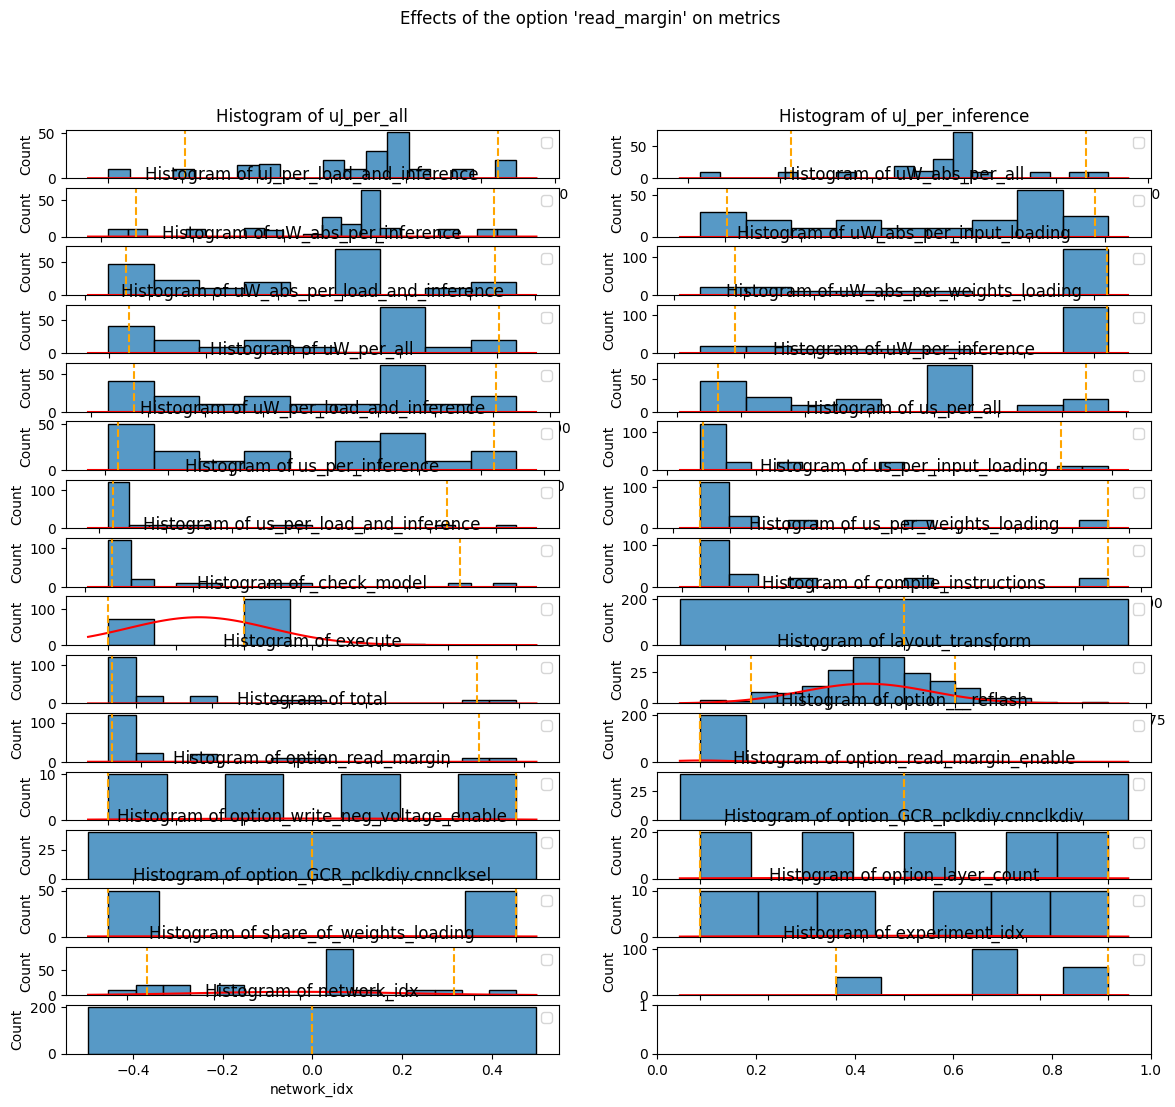

In [4]:
quantil = 0.95

def check_for_flash_vs_noflash():
    # can i see a difference between with and without flashing
    grouped = df.groupby(['experiment_idx', 'option___reflash']).mean('deploy').reset_index()
    # relative = grouped.pct_change()
    grouped_with_zero = [col for col in grouped.columns if (grouped[col] == 0).any()]
    relative_diffs = grouped.drop(columns=grouped_with_zero).pct_change().dropna()
    assert all(relative_diffs < 0.01) # diff is smaller than 1%

check_for_flash_vs_noflash()
data_overview_plot = get_data_overview(df_filtered.drop(columns=['uJ_per_input_loading', 'uJ_per_weights_loading','uW_per_input_loading', 'uW_per_weights_loading']))


In [9]:
# Create clock frequency mapping dictionaries
clkdiv_dict = {0: 2, 1: 4, 2: 8, 3: 16, 4: 1}  # Changed values based on documentation
clksel_dict = {0: 50, 1: 60}   # This was correct (0:PCLK, 1: ISO)

option_cnnclkdiv = 'option_GCR_pclkdiv.cnnclkdiv'
option_cnnclksel = 'option_GCR_pclkdiv.cnnclksel'

# Filter for rows that have both clock-related columns
clock_experiments = df_filtered.dropna(subset=[option_cnnclkdiv,
                                               option_cnnclksel,
                                               ])

# Calculate clock frequency only for relevant experiments
def calculate_clock_freq(row):
    try:
        div = clkdiv_dict[int(row[option_cnnclkdiv])]
        sel = clksel_dict[int(row[option_cnnclksel])]
        return sel / div
    except (KeyError, ValueError):
        return None

# Add clock frequency column
clock_experiments['clock_freq'] = clock_experiments.apply(calculate_clock_freq, axis=1)
# Add separate columns for clarity
clock_experiments['base_clock'] = clock_experiments[option_cnnclksel].map(clksel_dict)
clock_experiments['divider'] = clock_experiments[option_cnnclkdiv].map(clkdiv_dict)

clock_data = df_filtered.dropna(subset=[option_cnnclksel, option_cnnclkdiv])
clock_data['base_clock'] = clock_data[option_cnnclksel].map(clksel_dict)
clock_data['divider'] = clock_data[option_cnnclkdiv].map(clkdiv_dict)
clock_data['freq'] = clock_data['base_clock'] / clock_data['divider']

/tmp/ipykernel_488265/1845779943.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clock_experiments['clock_freq'] = clock_experiments.apply(calculate_clock_freq, axis=1)
/tmp/ipykernel_488265/1845779943.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clock_experiments['base_clock'] = clock_experiments[option_cnnclksel].map(clksel_dict)
/tmp/ipykernel_488265/1845779943.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [10]:
# Group by clock frequency and calculate mean and std for key metrics

# Analyze for each base clock
for base_clock in [50, 60]:
    subset = clock_experiments[clock_experiments['base_clock'] == base_clock]
    
    print(f"\nAnalysis for {base_clock}MHz base clock:")
    
    # Summary stats by divider
    stats = subset.groupby('divider').agg({
        'us_per_inference': ['mean', 'std'],
        'uW_per_inference': ['mean', 'std'],
        'us_per_all': ['mean', 'std'],
        'uW_per_all': ['mean', 'std'],
    }).round(3)
    
    print("\nSummary by divider:")
    print(stats)
    
    # ANOVA for dividers
    f_stat_time, p_val_time = scipy_stats.f_oneway(
        *[group['us_per_inference'].values for name, group in subset.groupby('divider')]
    )
    
    print(f"\nANOVA p-value for dividers: {p_val_time:.4f}")


Analysis for 50MHz base clock:

Summary by divider:
        us_per_inference         uW_per_inference         us_per_all         uW_per_all        
                    mean     std             mean     std       mean     std       mean     std
divider                                                                                        
1               3940.286   0.661        22815.130  24.104  10079.131   1.533  21162.370  64.289
2               7876.412   1.393        13624.790  13.929  16207.726   2.110  10183.910  69.155
4              15748.982   1.309         8222.800  12.307  28566.498   2.657   3048.490  69.803
8              31492.330   1.698         5348.578   9.977  53083.610   2.390  -1145.991  60.523
16             62974.510  11.277         3923.805   7.185  98962.510  11.513  -3365.400  61.440

ANOVA p-value for dividers: 0.0000

Analysis for 60MHz base clock:

Summary by divider:
        us_per_inference        uW_per_inference          us_per_all        uW_per_all    

In [70]:
# # Create boxplots separated by base clock to see the divider effects
# plt.figure(figsize=(12, 5))

# # Plot for 60MHz and 100MHz side by side
# plt.subplot(1, 2, 1)
# sns.boxplot(data=clock_experiments[clock_experiments['base_clock'] == 50],
#             x='divider', y='us_per_inference')
# plt.title('50 MHz Base Clock')
# plt.xlabel('Clock Divider')
# plt.ylabel('Inference Time (µs)')

# plt.subplot(1, 2, 2)
# sns.boxplot(data=clock_experiments[clock_experiments['base_clock'] == 60],
#             x='divider', y='us_per_inference')
# plt.title('60 MHz Base Clock')
# plt.xlabel('Clock Divider')
# plt.ylabel('Inference Time (µs)')

# plt.tight_layout()
# plt.show()

# # Print mean values for 60MHz to see if there's any trend despite non-significance
# print("\n60MHz means by divider:")
# print(clock_experiments[clock_experiments['base_clock'] == 60].groupby('divider')['us_per_inference'].mean())

/tmp/ipykernel_488265/3599826187.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_clock_data['us_per_all_corrected'] = base_clock_data['uW_per_all'] - base_clock_data['uW_per_weights_loading']
/tmp/ipykernel_488265/3599826187.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_clock_data['uW_per_all_corrected'] = base_clock_data['uW_per_all'] - base_clock_data['uW_per_weights_loading']


ValueError: not enough values to unpack (expected 3, got 2)

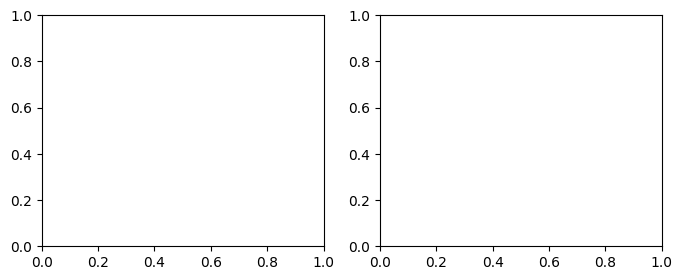

In [148]:
# Set rainbow palette with explicit color mapping
unique_freqs = sorted(clock_data['freq'].unique())
base_clock_data = clock_data[clock_data['freq'].isin([50, 60])]
base_clock_data['us_per_all_corrected'] = base_clock_data['uW_per_all'] - base_clock_data['uW_per_weights_loading']
base_clock_data['uW_per_all_corrected'] = base_clock_data['uW_per_all'] - base_clock_data['uW_per_weights_loading']
rainbow_palette = 'Set1' # dict(zip(unique_freqs, sns.color_palette('rainbow', n_colors=len(unique_freqs))))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# Time distribution
sns.kdeplot(data=base_clock_data, x='us_per_inference', hue='freq',
           palette=rainbow_palette, ax=ax1, linewidth=2, legend=False)
# ax1.set_title('Time Distribution by Frequency')
ax1.set_xlabel('Inference Time (µs)')
# Time distribution
# sns.kdeplot(data=base_clock_data, x='us_per_all', hue='freq',
#            palette=rainbow_palette, ax=ax2, linewidth=2, legend=True)
# # ax2.set_title('Time Distribution by Frequency')
# ax2.set_xlabel('Total Time (µs)')


# Power distribution
ax2_1 = sns.kdeplot(data=base_clock_data, x='uW_per_inference', hue='freq',
           palette=rainbow_palette, ax=ax2, linewidth=2, legend=False)
# ax2_2 = sns.kdeplot(data=base_clock_data, x='uW_per_all_corrected', hue='freq',
#            palette='Set2', ax=ax2, linewidth=2, legend=False)
# ax3.set_title('Power Distribution by Frequency')
ax2.set_xlabel('Power Consumption per inference (µW)')

# Power distribution
# sns.kdeplot(data=base_clock_data, x='uW_per_all', hue='freq',
#            palette=rainbow_palette, ax=ax4, linewidth=2, legend=False)
# # ax4.set_title('Power Distribution by Frequency')
# ax4.set_xlabel('Total Power Consumption (µW)')


# Get the lines from both plots
lines1 = ax2_1.get_lines()[::2]  # Get lines from first plot
lines2 = ax2_2.get_lines()[::2]  # Get lines from second plot
labels1 = [f'Inference ({freq} MHz)' for freq in base_clock_data['freq'].unique()]
labels2 = [f'corr. Cumulated ({freq} MHz)' for freq in base_clock_data['freq'].unique()]
set1_colors = sns.color_palette('Set1')[:2]
set2_colors = sns.color_palette('Set2')[:2]
freqs = ['50', '60']

from matplotlib.lines import Line2D
legend_elements = [
    # First set (rainbow palette)
    *[Line2D([0], [0], color=color, label=f'{freq} MHz (Inference)')
      for color, freq in zip(set1_colors, freqs)],
    # Second set (Set2 palette)
   #  *[Line2D([0], [0], color=color, label=f'{freq} MHz (All Operations)')
   #    for color, freq in zip(set2_colors, freqs)]
]
print([line.get_color() for line in legend_elements])

# Add legend
ax2.legend(handles=legend_elements,
          title='Power Consumption / Time',
          loc='upper left')

for ax in [ax1]:#[ax1, ax2]:
   ax.set_yticklabels([f"{float(y)*100:2.0f}%" for y in ax.get_yticks()])
for ax in [ax2]:# [ax3, ax4]:
   ax.set_yticklabels([f"{float(y)*100:2.2f}%" for y in ax.get_yticks()])

plt.suptitle('Time and Power Distribution by Base Clock frequency')
plt.tight_layout()
plt.savefig(figures_path / "05_npu_baseclocks.pdf", format='pdf', bbox_inches='tight')
# base_clock_data

In [16]:
# Filter for only base clocks (60 and 100 MHz)
base_clock_data = clock_data[clock_data['freq'].isin([50, 60])]

# Calculate metrics per MHz
base_clock_data['time_per_MHz'] = base_clock_data['us_per_inference'] / base_clock_data['freq']
base_clock_data['power_per_MHz'] = base_clock_data['uW_per_inference'] / base_clock_data['freq']

# Print summary statistics
print("Summary statistics by frequency:")
print(base_clock_data.groupby('freq')[['time_per_MHz', 'power_per_MHz']].agg(['mean', 'std']).round(3))

Summary statistics by frequency:
     time_per_MHz        power_per_MHz       
             mean    std          mean    std
freq                                         
50.0       78.806  0.013       456.303  0.482
60.0       54.790  0.006       348.082  2.490


/tmp/ipykernel_488265/1639498077.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_clock_data['time_per_MHz'] = base_clock_data['us_per_inference'] / base_clock_data['freq']
/tmp/ipykernel_488265/1639498077.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_clock_data['power_per_MHz'] = base_clock_data['uW_per_inference'] / base_clock_data['freq']


/tmp/ipykernel_488265/3875026350.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values('divider', ascending=True, inplace=True)
/tmp/ipykernel_488265/3875026350.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['divider_label'] = df['divider'].map({1: 'Div by 1', 2: 'Div by 2', 4: 'Div by 4', 8: 'Div by 8', 16: 'Div by 16'})
/tmp/ipykernel_488265/3875026350.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

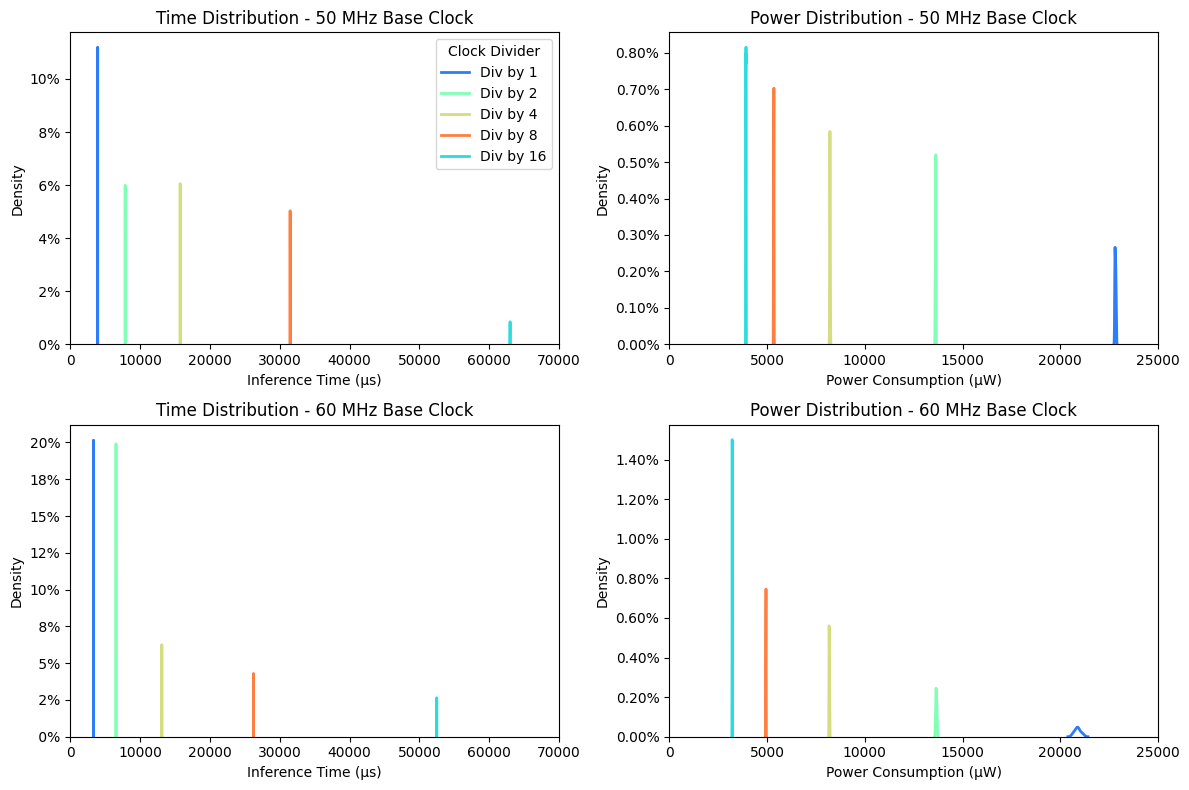

In [35]:
# Create separate dataframes for each base clock
slowclk = 50
fastclk = 60
data_slowclk = clock_data[(clock_data['base_clock'] == slowclk)]
data_fastclk = clock_data[(clock_data['base_clock'] == fastclk)]

# Add divider labels for each
for df in [data_slowclk, data_fastclk]:
   df.sort_values('divider', ascending=True, inplace=True)
   df['divider_label'] = df['divider'].map({1: 'Div by 1', 2: 'Div by 2', 4: 'Div by 4', 8: 'Div by 8', 16: 'Div by 16'})


# Create figure with subplots for both clock speeds
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))


# Set palettes
unique_divs = sorted(data_slowclk['divider_label'].unique())
rainbow_palette = dict(zip(unique_divs, sns.color_palette('rainbow', n_colors=len(unique_divs))))

# {slowclk} MHz plots
samples_slow = data_slowclk['divider_label'].value_counts()
title_slow = f'\n(n={", ".join([f"{div}: {count}" for div, count in samples_slow.items()])})'
title_slow = ''

sns.kdeplot(data=data_slowclk, x='us_per_inference', hue='divider_label',
           palette=rainbow_palette, ax=ax1, linewidth=2)
ax1.set_title(f'Time Distribution - {slowclk} MHz Base Clock{title_slow}')
ax1.set_xlabel('Inference Time (µs)')

sns.kdeplot(data=data_slowclk, x='uW_per_inference', hue='divider_label',
           palette=rainbow_palette, ax=ax2, linewidth=2, legend=False)
ax2.set_title(f'Power Distribution - {slowclk} MHz Base Clock')
ax2.set_xlabel('Power Consumption (µW)')

# {fastclk} MHz plots
samples_50 = data_fastclk['divider_label'].value_counts()
title_50 = f'\n(n={", ".join([f"{div}: {count}" for div, count in samples_50.items()])})'
title_50 = ''

sns.kdeplot(data=data_fastclk, x='us_per_inference', hue='divider_label',
           palette=rainbow_palette, ax=ax3, linewidth=2, legend=False)
ax3.set_title(f'Time Distribution - {fastclk} MHz Base Clock{title_50}')
ax3.set_xlabel('Inference Time (µs)')

sns.kdeplot(data=data_fastclk, x='uW_per_inference', hue='divider_label',
           palette=rainbow_palette, ax=ax4, linewidth=2, legend=False)
ax4.set_title(f'Power Distribution - {fastclk} MHz Base Clock')
ax4.set_xlabel('Power Consumption (µW)')


for ax in [ax1, ax3]:
   ax.set_xticks(np.linspace(0, 70_000, num=8))
   ax.set_yticklabels([f"{float(y)*100:2.0f}%" for y in ax.get_yticks()])
for ax in [ax2, ax4]:
   ax.set_xticks(np.linspace(0, 25_000, num=6))
   ax.set_yticklabels([f"{float(y)*100:2.2f}%" for y in ax.get_yticks()])

# Modify legend
leg = ax1.get_legend()
leg.set_title("Clock Divider")

plt.tight_layout()
plt.savefig(figures_path / "05_npu_clockdividers.pdf", format='pdf', bbox_inches='tight')

/tmp/ipykernel_488265/2519136964.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_slowclk['energy_uJ'] = (data_slowclk['us_per_inference'] * data_slowclk['uW_per_inference']).apply(lambda x:x/1000_000)
/tmp/ipykernel_488265/2519136964.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fastclk['energy_uJ'] = (data_fastclk['us_per_inference'] * data_fastclk['uW_per_inference']).apply(lambda x:x/1000_000)
/tmp/ipykernel_488265/2519136964.py:8: SettingWithCopyWarning: 
A value is trying to be set 

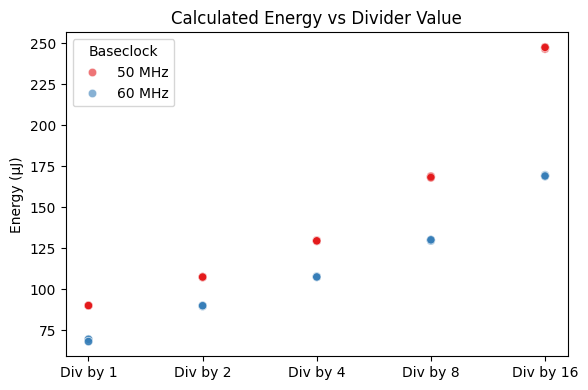

In [146]:
data_slowclk = clock_data[(clock_data['base_clock'] == slowclk)]
data_fastclk = clock_data[(clock_data['base_clock'] == fastclk)]

data_slowclk['energy_uJ'] = (data_slowclk['us_per_inference'] * data_slowclk['uW_per_inference']).apply(lambda x:x/1000_000)
data_fastclk['energy_uJ'] = (data_fastclk['us_per_inference'] * data_fastclk['uW_per_inference']).apply(lambda x:x/1000_000)
# Add divider labels for each
for df in [data_slowclk, data_fastclk]:
   df.sort_values('divider', ascending=True, inplace=True)
   df['divider_label'] = df['divider'].map({1: 'Div by 1', 2: 'Div by 2', 4: 'Div by 4', 8: 'Div by 8', 16: 'Div by 16'})


# Combine the datasets
data_combined = pd.concat([data_slowclk, data_fastclk])

data_combined['baseclock_label'] = data_combined['base_clock'].apply(lambda x: f'{x} MHz')

# Create scatter plot using seaborn
plt.figure(figsize=(6, 4))
ax1 = sns.scatterplot(data=data_combined,
                x='divider_label',
                y='energy_uJ',
                hue='baseclock_label',
                alpha=0.6,
                palette="Set1",
                )

plt.xlabel('')
plt.ylabel('Energy (µJ)')
plt.title('Calculated Energy vs Divider Value')

lx = ax1.get_legend()
lx.set_title('Baseclock')

# Add vertical separators between layer groups
# layer_counts = sorted(data_slowclk['divider_label'].unique())
# for x in layer_counts[:-1]:
#     plt.axvline(x + 0.5, color='gray', linestyle='-', alpha=0.2)

# Convert x-axis labels to integers
# plt.gca().set_xticklabels([int(x) for x in plt.gca().get_xticks()])

plt.tight_layout()
plt.savefig(figures_path / "05_npu_clockdividers_energy.pdf", format='pdf', bbox_inches='tight')

In [37]:
# # Create separate dataframes for each base clock
# data_slowclk = clock_data[(clock_data['base_clock'] == 60)]
# data_fastclk = clock_data[(clock_data['base_clock'] == 100)]

# # Add divider labels for each
# for df in [data_slowclk, data_fastclk]:
#    df.sort_values('divider', ascending=True, inplace=True)
#    df['divider_label'] = df['divider'].map({1: 'Div by 1', 2: 'Div by 2', 4: 'Div by 4', 8: 'Div by 8', 16: 'Div by 16'})


# # Create figure with subplots for both clock speeds
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# # Set palettes
# unique_divs = sorted(data_slowclk['divider_label'].unique())
# rainbow_palette = dict(zip(unique_divs, sns.color_palette('rainbow', n_colors=len(unique_divs))))

# # 60MHz plots
# samples_60 = data_slowclk['divider_label'].value_counts()
# title_60 = f'\n(n={", ".join([f"{div}: {count}" for div, count in samples_60.items()])})'

# sns.boxplot(data=data_slowclk, x='us_per_inference', hue='divider_label',
#            palette=rainbow_palette, ax=ax1, linewidth=2)
# ax1.set_title(f'Time Distribution - 60MHz Base Clock{title_60}')
# ax1.set_xlabel('Inference Time (µs)')

# sns.boxplot(data=data_slowclk, x='uW_per_inference', hue='divider_label',
#            palette=rainbow_palette, ax=ax2, linewidth=2, legend=False)
# ax2.set_title('Power Distribution - 60MHz Base Clock')
# ax2.set_xlabel('Power Consumption (µW)')

# # 100MHz plots
# samples_100 = data_fastclk['divider_label'].value_counts()
# title_100 = f'\n(n={", ".join([f"{div}: {count}" for div, count in samples_100.items()])})'

# sns.boxplot(data=data_fastclk, x='us_per_inference', hue='divider_label',
#            palette=rainbow_palette, ax=ax3, linewidth=2)
# ax3.set_title(f'Time Distribution - 100MHz Base Clock{title_100}')
# ax3.set_xlabel('Inference Time (µs)')

# sns.boxplot(data=data_fastclk, x='uW_per_inference', hue='divider_label',
#            palette=rainbow_palette, ax=ax4, linewidth=2, legend=False)
# ax4.set_title('Power Distribution - 100MHz Base Clock')
# ax4.set_xlabel('Power Consumption (µW)')

# # Modify legend
# leg = ax1.get_legend()
# leg.set_title("Clock Divider")
# leg._fontsize = 8
# leg.get_title().set_fontsize(8)
# leg._legend_box.sep = 1
# leg._legend_box.pad = 0.1

# plt.tight_layout()
# plt.savefig(figures_path / "05_npu_clockdividers_hist.pdf", format='pdf', bbox_inches='tight')

/tmp/ipykernel_488265/918428801.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  margin_data['read_margin'] = margin_data['option_read_margin'].map(margin_labels)
/tmp/ipykernel_488265/918428801.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_yticklabels([f'{y*100:2.2f} %' for y in y3_ticks])
/tmp/ipykernel_488265/918428801.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_yticklabels([f'{y}' for y in y4_ticks])


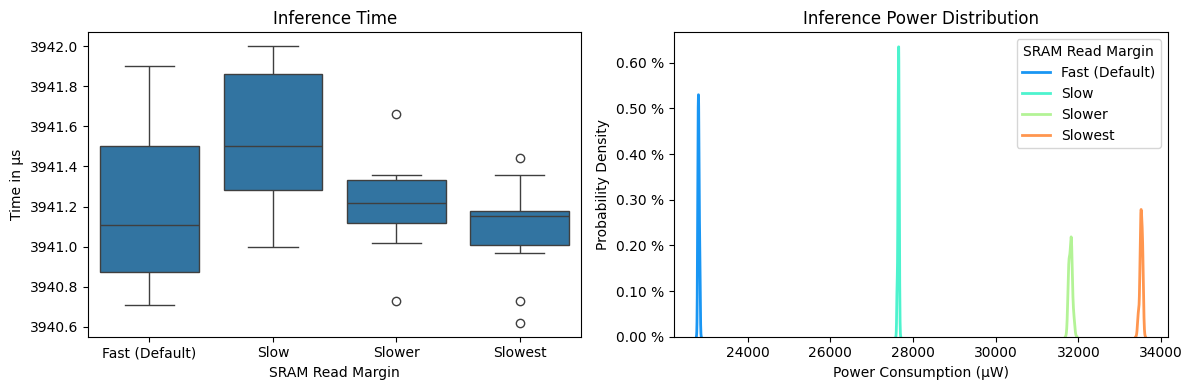

In [67]:
margin_labels = {
   0: 'Slowest',
   1: 'Slower',
   2: 'Slow',
   3: 'Fast (Default)',
}

margin_data = df_filtered.dropna(subset=['option_read_margin'])
margin_data['read_margin'] = margin_data['option_read_margin'].map(margin_labels)

samples_per_option = margin_data['read_margin'].value_counts()
# title_suffix = f'\n$n={min([]+[x for x in samples_per_option])}$ per option'
title_suffix = ''

# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))
fig, ((ax1, ax3)) = plt.subplots(1, 2, figsize=(12, 4))

# Time boxplots
sns.boxplot(data=margin_data, x='read_margin', y='us_per_inference', ax=ax1)
ax1.set_title(f'Inference Time{title_suffix}')
ax1.set_ylabel('Time in µs')
ax1.set_xlabel('SRAM Read Margin')

sns.boxplot(data=margin_data, x='read_margin', y='us_per_all', ax=ax2)
ax2.set_title(f'Total Time{title_suffix}')
ax2.set_ylabel('Time in µs')
ax2.set_xlabel('SRAM Read Margin')

# Power distributions
unique_margins = sorted(margin_data['read_margin'].unique())
rainbow_palette = dict(zip(unique_margins, sns.color_palette('rainbow', n_colors=len(unique_margins))))

n_samples = len(margin_data)

# Create KDE plots and save the legend handles from one plot
kde1 = sns.kdeplot(data=margin_data, x='uW_abs_per_inference', hue='read_margin',
                  palette=rainbow_palette, ax=ax3, linewidth=2, legend=True)
ax3.set_title('Inference Power Distribution')
ax3.set_xlabel('Power Consumption (µW)')


# Add a single legend at the bottom center
handles, labels = ax3.get_legend_handles_labels()
y3_ticks = ax3.get_yticks()
ax3.set_yticklabels([f'{y*100:2.2f} %' for y in y3_ticks])
ax3.set_ylabel('Probability Density')

kde2 = sns.kdeplot(data=margin_data, x='uW_per_all', hue='read_margin', 
                  palette=rainbow_palette, ax=ax4, linewidth=2, legend=False)
ax4.set_title('Total Power Distribution')
ax4.set_xlabel('Power Consumption (µW)')
y4_ticks = ax4.get_yticks()
ax4.set_yticklabels([f'{y}' for y in y4_ticks])
ax4.set_ylabel('Probability\nDensity')


# Get and modify legend
leg = ax3.get_legend()
# leg.set_bbox_to_anchor((0.45, 0.35), transform=fig.transFigure) # Center of figure
leg.set_title('SRAM Read Margin')
# leg.set_zorder(1000)  # Set high z-index to show legend on top
# leg.get_frame().set_alpha(1.0)  # Make legend background fully opaque
# leg.get_frame().set_facecolor('white')  # Ensure white background

plt.subplots_adjust(wspace=-0.5, right=0.95, left=0.05)
plt.tight_layout()

plt.savefig(figures_path / "05_npu_read_margin.pdf", format='pdf', bbox_inches='tight')

/home/vscode/_Masterarbeit_SS24/hannah-env/service/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/vscode/_Masterarbeit_SS24/hannah-env/service/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/vscode/_Masterarbeit_SS24/hannah-env/service/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_488265/1308053970.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(x+1)

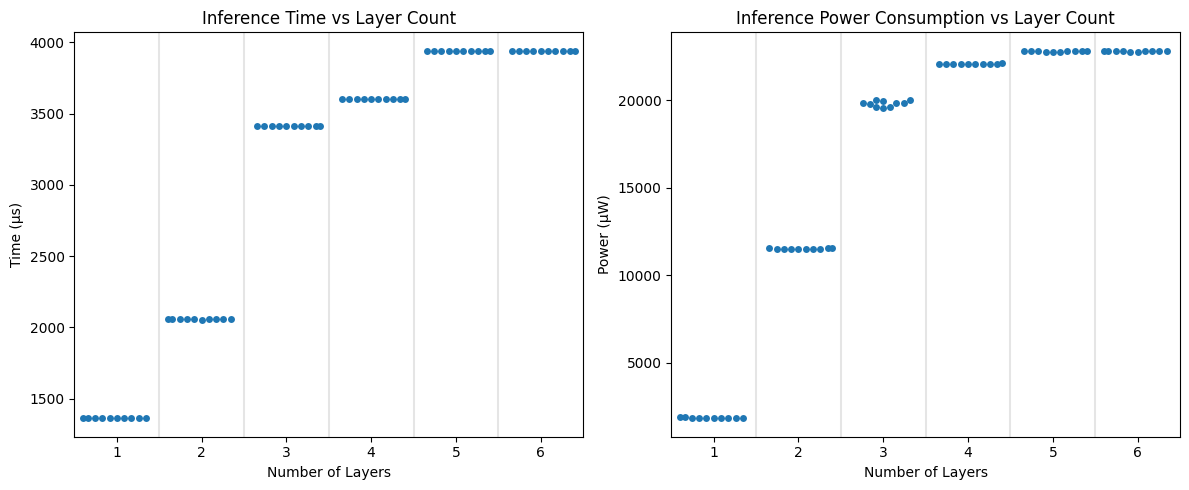

In [69]:
# Create subplots for time and power vs layer count
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Time plot
sns.swarmplot(data=df_filtered, x='option_layer_count', y='us_per_inference',
              ax=ax1)
ax1.set_title('Inference Time vs Layer Count')
ax1.set_xlabel('Number of Layers')
ax1.set_ylabel('Time (µs)')

# Add vertical lines between groups for time plot
layer_counts = sorted(df_filtered['option_layer_count'].unique())
for x in layer_counts[:-1]:  # All except the last one
    ax1.axvline(x + 0.5, color='gray', linestyle='-', alpha=0.2)

# Power plot
sns.swarmplot(data=df_filtered, x='option_layer_count', y='uW_abs_per_inference',
              ax=ax2)
ax2.set_title('Inference Power Consumption vs Layer Count')
ax2.set_xlabel('Number of Layers')
ax2.set_ylabel('Power (µW)')

# Add vertical lines between groups for power plot
for x in layer_counts[:-1]:  # All except the last one
    ax2.axvline(x + 0.5, color='gray', linestyle='-', alpha=0.2)

ax1.set_xticklabels([int(x+1) for x in ax1.get_xticks()])
ax2.set_xticklabels([int(x+1) for x in ax2.get_xticks()])

plt.tight_layout()
plt.savefig(figures_path / "05_npu_per_layer.pdf", format='pdf', bbox_inches='tight')